# Team Ernst Engel Nutritional Content Notebook
In this notebook, we obtain the nutritional contents for the foods of interest for our project. Moreover, we examine the nutritional adequacy of the diets of the housholds in our analysis.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, widgets
import fooddatacentral as fdc

# This is a local file unique to Jordan's computer
# It contains his USDA FoodData Central API Key
# Keep Commented or it will cause an error
import config

## Getting Nutritional Contents

In [129]:
foods_oi = pd.read_csv('./data/foods_oi.csv').set_index('Food')
apikey = config.API_KEY
diet_refs = pd.read_csv('./data/us_diet_minimums.csv')
dr_categories = diet_refs['Nutrition'].values

In [131]:
def get_nutritional_content(foods_oi, apikey, dr_categories):
    '''
    Description
    --------------------------------------------------
    Gets the nutritional content for the food of 
    interest.
    
    Inputs
    --------------------------------------------------
    + foods_oi : pandas dataframe; foods of interest
        with their FDC id
    + apikey : string; FoodData Central API key
    + dr_categories : array; USDA dietary requirment
        categories
    
    Outputs
    --------------------------------------------------
    + food_nutrients : pandas dataframe; contains the
        nutritional contents of all foods of interest
        for the dr_categories
    '''
    food_nutrients = {}
    for food in foods_oi.index:
        try:
            FDC = foods_oi.loc[food,'FDC']
            food_nutrients[food] = fdc.nutrients(apikey,FDC).Quantity
        except:
            pass

    food_nutrients = pd.DataFrame(food_nutrients,dtype=float)

    food_nutrients = food_nutrients[food_nutrients.index.isin(dr_categories)].fillna(0)
    return food_nutrients

In [133]:
food_nutrients = get_nutritional_content(foods_oi, apikey, dr_categories)
food_nutrients

,Wheat Flour,Wheat Cereal,Corn Meal,Rolled Oats,Evaporated Milk,Cabbage,Potatoes,Spinach,Sweet Potatoes,Navy Beans,Sugar,Beets,Milk (Whole),Liver (Beef)
"Calcium, Ca",0.0,19.000,0.000,52.0,267.00,40.000,0.00,99.000,35.00,49.00,1.000,16.000,123.000,5.000
"Carbohydrate, by difference",70.7,76.300,78.790,67.5,10.00,5.800,16.89,3.630,20.00,16.13,99.770,9.560,4.630,3.890
Energy,345.0,359.000,345.000,375.0,133.00,103.000,74.00,97.000,82.00,97.00,1627.000,180.000,61.000,564.000
"Fiber, total dietary",2.6,10.400,0.000,10.0,0.00,2.500,2.00,2.200,3.50,4.00,0.000,2.800,0.000,0.000
"Folate, DFE",0.0,220.000,0.000,0.0,0.00,43.000,0.00,194.000,0.00,0.00,0.000,109.000,0.000,290.000
"Iron, Fe",0.0,27.600,0.000,5.0,0.00,0.470,0.73,2.710,0.59,1.61,0.060,0.800,0.000,4.900
"Magnesium, Mg",0.0,30.000,0.000,0.0,0.00,12.000,0.00,79.000,0.00,0.00,0.000,23.000,12.000,18.000
Niacin,0.0,7.250,5.455,0.0,0.00,0.234,0.00,0.724,0.00,0.00,0.000,0.334,0.105,13.175
"Phosphorus, P",0.0,112.000,0.000,0.0,0.00,26.000,0.00,49.000,0.00,0.00,0.000,40.000,101.000,387.000
"Potassium, K",0.0,126.000,167.000,352.0,300.00,170.000,439.00,558.000,341.00,323.00,2.000,325.000,150.000,313.000


## Examing Nutritional Adequacy

In [311]:
diet_refs = pd.read_csv('./data/uganda_rdi.csv')
dr_categories = diet_refs['n'].values

In [189]:
country = 'uganda'
year_range = '2019-20'
food_nutrients = pd.read_csv(f'./data/{country}_fct.csv')#.set_index('n')
food_prices = pd.read_csv(f'./data/{country}_food_prices.csv').fillna(0)
hh_chars = pd.read_csv(f'./data/{country}_hh_chars.csv')
### Deals With Housholds from an  Unknown Region
hh_chars['m'] = hh_chars['m'].fillna('Unknown')
expenditures = pd.read_csv(f'./data/{country}_expenditures_{year_range[-5:]}.csv').fillna(0)

In [191]:
hhc_sub = hh_chars[hh_chars['t'] == year_range].reset_index(drop = True)
fp_sub = food_prices[food_prices['t'] == year_range].set_index('m').drop(columns = ['t'])
food_cols = expenditures.iloc[0:2, 3:].columns
fp_sub_avgs = fp_sub.reset_index(drop = True)
fp_sub_avgs = pd.DataFrame(fp_sub_avgs.mean()).rename(columns = {0 : 'Mean_Price'})

In [193]:
def get_col_counts(expenditures_df, food_col, prices, price_avs):
    counts = []
    for idx in expenditures_df.index:
        region = expenditures_df.loc[idx, 'm']
        expenditure = expenditures_df.loc[idx, food_col]
        if region == 'Unknown':
            # Imputes price from unknown region with the mean accross all regions
            price = fp_sub_avgs.loc[food_col][0]
            if price == 0: # Don't want to divide by zero
                count = 0
                counts.append(count)
            else:
                count = expenditure / price
                counts.append(count)   
        else:
            price = prices.loc[region, food_col]
            if price == 0: # Don't want to divide by zero
                count = 0
                counts.append(count)
            else:
                count = expenditure / price
                counts.append(count)
    return counts

In [195]:
def get_counts(expenditures_df, food_cols, prices, price_avs):
    count_df = expenditures_df.drop(columns = food_cols)
    for food_col in food_cols:
        counts = get_col_counts(expenditures_df, food_col, prices, price_avs)
        count_df[food_col] = counts
    return count_df

In [197]:
exp_counts = get_counts(expenditures, food_cols, fp_sub, fp_sub_avgs)

In [299]:
household_master = hhc_sub.merge(exp_counts, left_on = ['i', 't', 'm'], right_on = ['i', 't', 'm'])

In [301]:
hhc_sub_num = hhc_sub.set_index('i').iloc[:, 2:-1]
hhc_sub_num

,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+
i,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,1.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
062da72d5d3a457e9336b62c8bb9096d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0d0e29faff394154a69562b4527b48b8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
0e03e253c35d4333a1ffad2df9d38850,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1013000201,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c33f6cb57d9849949e08a7350dabb829,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d10a687889de469687377204195f3db0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
d24fa50d02c041969a42102d8ebdadc9,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [331]:
# If expenditures weekly, extrapolation_constant = 7
# If expenditures daily, extrapolation_constant = 1
extrapolation_constant = 7

# Commented b/c we working with the Uganda data rn
# diet_refs_rev = diet_refs.set_index('Nutrition').drop(columns = ['Source']).rename(columns = {'C 1-3' : 'F 00-03', 
#                                                                                               'F 4-8' : 'F 04-08',
#                                                                                               'M 4-8' : 'M 04-08',
#                                                                                               'F 9-13' : 'F 09-13',
#                                                                                               'M 9-13' : 'M 09-13'})
# diet_refs_rev['M 00-03'] = diet_refs_rev['F 00-03']
diet_refs_rev = diet_refs.set_index('n')
diet_refs_rev = diet_refs_rev[hhc_sub_num.columns] # Reorders columns
diet_refs_rev = extrapolation_constant * diet_refs_rev
diet_refs_rev

,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+
n,,,,,,,,,,,,,,
Energy,7000.0,8400.0,11200.0,12600.0,14000.0,12600.0,11200.0,7000.0,9800.0,12600.0,15400.0,16800.0,15400.0,14000.0
Protein,91.0,133.0,238.0,322.0,322.0,322.0,322.0,91.0,133.0,238.0,364.0,392.0,392.0,392.0
Fiber,98.0,117.6,156.8,176.4,196.0,176.4,156.8,98.0,137.2,176.4,215.6,235.2,215.6,196.0
Folate,1050.0,1400.0,2100.0,2800.0,2800.0,2800.0,2800.0,1050.0,1400.0,2100.0,2800.0,2800.0,2800.0,2800.0
Calcium,4900.0,7000.0,9100.0,9100.0,7000.0,7000.0,8400.0,4900.0,7000.0,9100.0,9100.0,7000.0,7000.0,7000.0
Carbohydrate,910.0,910.0,910.0,910.0,910.0,910.0,910.0,910.0,910.0,910.0,910.0,910.0,910.0,910.0
Iron,49.0,70.0,56.0,105.0,126.0,126.0,56.0,49.0,70.0,56.0,77.0,56.0,56.0,56.0
Magnesium,560.0,910.0,1680.0,2520.0,2170.0,2240.0,2240.0,560.0,910.0,1680.0,2870.0,2800.0,2940.0,2940.0
Niacin,42.0,56.0,84.0,98.0,98.0,98.0,98.0,42.0,56.0,84.0,112.0,112.0,112.0,112.0


In [333]:
diet_refs_rev.shape

(20, 14)

In [335]:
hh_diet_reqs = hhc_sub_num @ diet_refs_rev.T
hh_diet_reqs

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Magnesium,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin E,Vitamin K,Zinc
i,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,82600.0,1939.0,1156.4,17150.0,56700.0,6370.0,602.0,14210.0,616.0,48020.0,217000.0,46.2,46.2,30800.0,102.9,55.3,2835.0,644.0,3465.0,378.0
062da72d5d3a457e9336b62c8bb9096d,15400.0,392.0,215.6,2800.0,7000.0,910.0,56.0,2940.0,112.0,4900.0,32900.0,9.1,8.4,6300.0,16.8,9.1,630.0,105.0,840.0,77.0
0d0e29faff394154a69562b4527b48b8,43400.0,896.0,607.6,7700.0,23800.0,3640.0,280.0,6230.0,294.0,16240.0,107800.0,23.8,23.1,15400.0,46.2,25.2,1365.0,294.0,1890.0,175.0
0e03e253c35d4333a1ffad2df9d38850,56000.0,1176.0,784.0,10150.0,35000.0,4550.0,357.0,8260.0,392.0,25270.0,144900.0,30.8,30.1,20300.0,60.9,32.9,1750.0,378.0,2485.0,245.0
1013000201,11200.0,322.0,156.8,2800.0,8400.0,910.0,56.0,2240.0,98.0,4900.0,32900.0,7.7,7.7,4900.0,16.8,10.5,525.0,105.0,630.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c33f6cb57d9849949e08a7350dabb829,11200.0,322.0,156.8,2800.0,8400.0,910.0,56.0,2240.0,98.0,4900.0,32900.0,7.7,7.7,4900.0,16.8,10.5,525.0,105.0,630.0,56.0
d10a687889de469687377204195f3db0,42000.0,1078.0,588.0,8400.0,24500.0,2730.0,189.0,8050.0,322.0,18550.0,98700.0,25.9,24.5,17500.0,50.4,28.7,1680.0,315.0,1995.0,210.0
d24fa50d02c041969a42102d8ebdadc9,95200.0,2128.0,1332.8,17850.0,60200.0,7280.0,574.0,15330.0,686.0,47670.0,242200.0,53.2,51.8,35700.0,107.1,60.2,3150.0,665.0,4270.0,441.0


In [337]:
hh_consumption_cols = list(food_cols.to_numpy())
hh_consumption_cols.append('i')

hh_consumption = household_master[hh_consumption_cols].set_index('i')
hh_consumption

,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
i,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,1.582418,0.00,0.000000,0.0,0.0,0.000000,0.0,0.833636,0.0,4.857143,...,0.0,0.000000,5.034965,0.020000,1.600000,0.0,0.0,0.0,0.865775,0.0
062da72d5d3a457e9336b62c8bb9096d,0.000000,0.00,0.000000,0.0,0.0,0.111111,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
0d0e29faff394154a69562b4527b48b8,0.439560,0.45,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,3.238095,...,0.0,0.000000,0.000000,0.000000,1.280000,0.0,0.0,0.0,0.000000,0.0
0e03e253c35d4333a1ffad2df9d38850,1.230769,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,2.590476,...,0.0,0.000000,6.293706,0.020000,0.800000,0.0,0.0,0.0,0.000000,0.0
1013000201,0.000000,0.00,2.916667,0.0,0.0,0.000000,0.0,0.000000,0.0,2.857143,...,0.0,1.709975,0.000000,0.030769,3.126136,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,0.527473,1.00,0.000000,0.0,2.8,0.000000,0.0,0.297727,0.0,2.590476,...,0.0,0.000000,7.552448,0.010000,1.600000,0.0,0.0,0.0,0.288592,0.0
c33f6cb57d9849949e08a7350dabb829,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.785714,...,0.0,0.000000,1.290323,0.015385,1.488636,0.0,0.0,0.0,0.000000,0.0
d10a687889de469687377204195f3db0,0.909091,0.00,0.000000,0.0,0.0,0.000000,0.0,0.425325,0.0,0.000000,...,0.0,0.000000,2.720000,0.000000,1.333333,0.0,0.0,0.0,0.000000,0.0


In [339]:
fn_rev = food_nutrients[food_nutrients['j'].isin(hh_consumption.columns)].rename(columns = {'j' : 'Food'}).set_index('Food')
food_nutrients

,j,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
0,Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
1,Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
2,Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
3,Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
4,Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Tomatoes,180,9.0,10.0,150,100,39.0,3.0,5.94,0.19,0.37,420,0.0,0.80,127,2.0
99,Waragi,2630,0.0,0.0,0,0,0.0,0.0,0.00,0.00,0.00,0,0.0,0.00,0,0.0
100,Watermelon,300,6.1,4.0,30,70,75.5,2.4,1.78,0.21,0.33,280,0.0,0.45,81,1.0
101,Wheat (flour),3640,103.0,30.0,260,150,763.0,12.0,12.50,0.40,1.20,0,0.0,0.44,0,7.0


In [341]:
hh_consumption_rev = hh_consumption[fn_rev.index.to_numpy()]
hh_consumption_rev

,Beef,Biscuits,Bongo,Bread,Cabbages,Cassava (flour),Chapati,Cooking Oil,Dodo,Eggs,...,Pork,Sim Sim,Soda,Sorghum,Sugar,Sugarcane,Sweet Bananas,Tomatoes,Waragi,Wheat (flour)
i,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,0.00,0.0,0.0,0.000000,0.833636,0.0,1.714286,0.810811,3.00,0.0,...,0.000000,0.0,0.60,0.000000,0,0.0,0.000000,1.600000,0.0,0.0
062da72d5d3a457e9336b62c8bb9096d,0.00,0.0,0.0,0.111111,0.000000,0.0,0.571429,0.000000,0.00,0.0,...,0.000000,0.0,0.60,0.000000,0,0.0,0.000000,0.000000,0.0,0.0
0d0e29faff394154a69562b4527b48b8,0.45,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,...,0.000000,0.0,0.00,1.500000,0,0.0,0.000000,1.280000,0.0,0.0
0e03e253c35d4333a1ffad2df9d38850,0.00,0.0,0.0,0.000000,0.000000,0.0,0.857143,0.486486,2.40,0.0,...,0.000000,0.0,0.00,0.000000,0,0.0,0.000000,0.800000,0.0,0.0
1013000201,0.00,0.0,0.0,0.000000,0.000000,0.0,12.000000,0.660000,0.00,0.0,...,0.833333,0.0,0.72,0.000000,0,0.0,1.709975,3.126136,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,1.00,0.0,2.8,0.000000,0.297727,0.0,1.714286,0.432432,0.75,0.0,...,0.000000,0.0,0.90,0.000000,0,0.0,0.000000,1.600000,0.0,0.0
c33f6cb57d9849949e08a7350dabb829,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.90,0.0,...,0.000000,0.0,0.00,0.000000,0,0.0,0.000000,1.488636,0.0,0.0
d10a687889de469687377204195f3db0,0.00,0.0,0.0,0.000000,0.425325,0.0,0.000000,0.000000,0.00,0.0,...,0.000000,0.0,0.00,0.000000,0,0.0,0.000000,1.333333,0.0,0.0


In [343]:
hh_consumption_nutrients = hh_consumption_rev @ fn_rev
hh_consumption_nutrients

,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,21027.690944,323.451558,202.437662,4666.320779,9877.025974,2794.193766,133.853896,96.268995,8.967455,11.717661,8142.253247,0.000,22.207995,3731.168052,59.467273
062da72d5d3a457e9336b62c8bb9096d,2154.984127,60.444444,13.650794,260.476190,689.206349,448.307937,12.711111,17.112222,0.922063,2.031270,0.000000,0.000,0.287619,0.000000,5.949206
0d0e29faff394154a69562b4527b48b8,6604.900000,267.320000,110.800000,505.000000,671.500000,1206.120000,79.190000,66.163200,3.213200,4.633600,537.600000,13.005,5.464000,192.160000,44.010000
0e03e253c35d4333a1ffad2df9d38850,14730.826255,197.071429,116.857143,2879.857143,6617.571428,2023.957143,101.628571,63.835429,5.951143,6.982571,6982.857143,0.000,18.956571,2077.285714,42.085714
1013000201,43099.248832,1306.064951,330.960609,3812.382092,11009.045712,7323.413585,190.735000,324.901249,15.691581,41.353429,1380.943185,5.250,17.193850,581.867130,123.065556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,23103.063092,556.391883,232.931818,3350.094156,10280.305195,3201.853896,106.467208,122.487110,11.876662,14.293256,6400.743506,41.220,24.417182,3708.803896,95.188312
c33f6cb57d9849949e08a7350dabb829,594.954545,39.197727,20.886364,1045.295454,2152.863636,121.956818,25.765909,15.124500,1.794841,0.943795,1939.227272,0.000,3.278909,600.956818,11.677273
d10a687889de469687377204195f3db0,8167.988312,172.347792,174.378788,1642.746753,698.234632,1535.940260,55.298052,75.744731,4.429249,7.395081,2090.409091,0.003,11.785226,712.916450,29.088745


In [365]:
common_columns = hh_consumption_nutrients.columns.intersection(hh_consumption_nutrients.columns)
common_rows = set(hh_consumption_nutrients.index).intersection(hh_consumption_nutrients.index)

### Gets common columns
hh_consumption_nutrients_rev = hh_consumption_nutrients[common_columns]
hh_diet_reqs_rev = hh_diet_reqs[common_columns]

### Gets common rows
hh_consumption_nutrients_rev = hh_consumption_nutrients_rev[hh_consumption_nutrients_rev.index.isin(common_rows)]
hh_diet_reqs_rev = hh_diet_reqs_rev[hh_diet_reqs_rev.index.isin(common_rows)]

In [409]:
hh_diet_adequacy = hh_consumption_nutrients_rev / hh_diet_reqs_rev
nutrient_cols = hh_diet_adequacy.columns

In [439]:
hh_diet_adequacy['adequate_diet'] = (hh_diet_adequacy >= 1).sum(axis=1) / len(nutrient_cols)
hh_diet_adequacy['adequate_diet_75pct'] = (hh_diet_adequacy >= 0.75).sum(axis=1) / len(nutrient_cols)
hh_diet_adequacy['adequate_diet_50pct'] = (hh_diet_adequacy >= 0.5).sum(axis=1) / len(nutrient_cols)

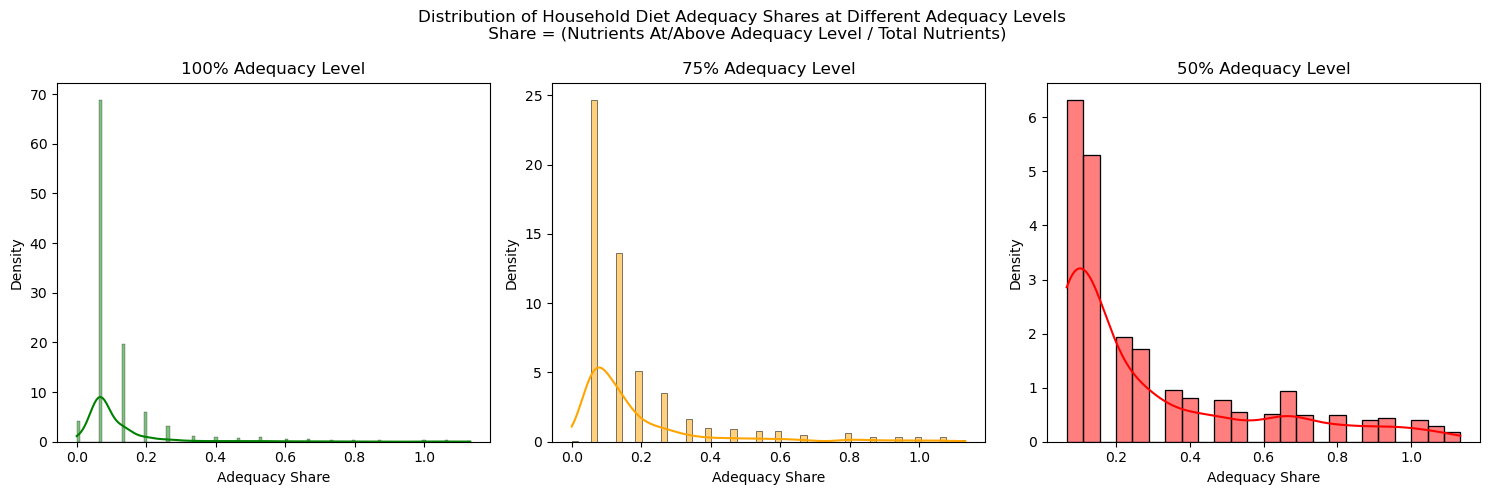

In [502]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data = hh_diet_adequacy, x = 'adequate_diet', 
             stat='density', kde = True, color = 'green', ax = axs[0])
sns.histplot(data = hh_diet_adequacy, x = 'adequate_diet_75pct', 
             stat='density', kde = True, color = 'orange', ax = axs[1])
sns.histplot(data = hh_diet_adequacy, x = 'adequate_diet_50pct', 
             stat='density', kde = True, color = 'red', ax = axs[2])

plt.suptitle('Distribution of Household Diet Adequacy Shares at Different Adequacy Levels \n Share = (Nutrients At/Above Adequacy Level / Total Nutrients)')

axs[0].set_title('100% Adequacy Level')
axs[1].set_title('75% Adequacy Level')
axs[2].set_title('50% Adequacy Level')

for ax in axs:
    ax.set_xlabel('Adequacy Share')

plt.tight_layout()

# Show the plots
plt.show();

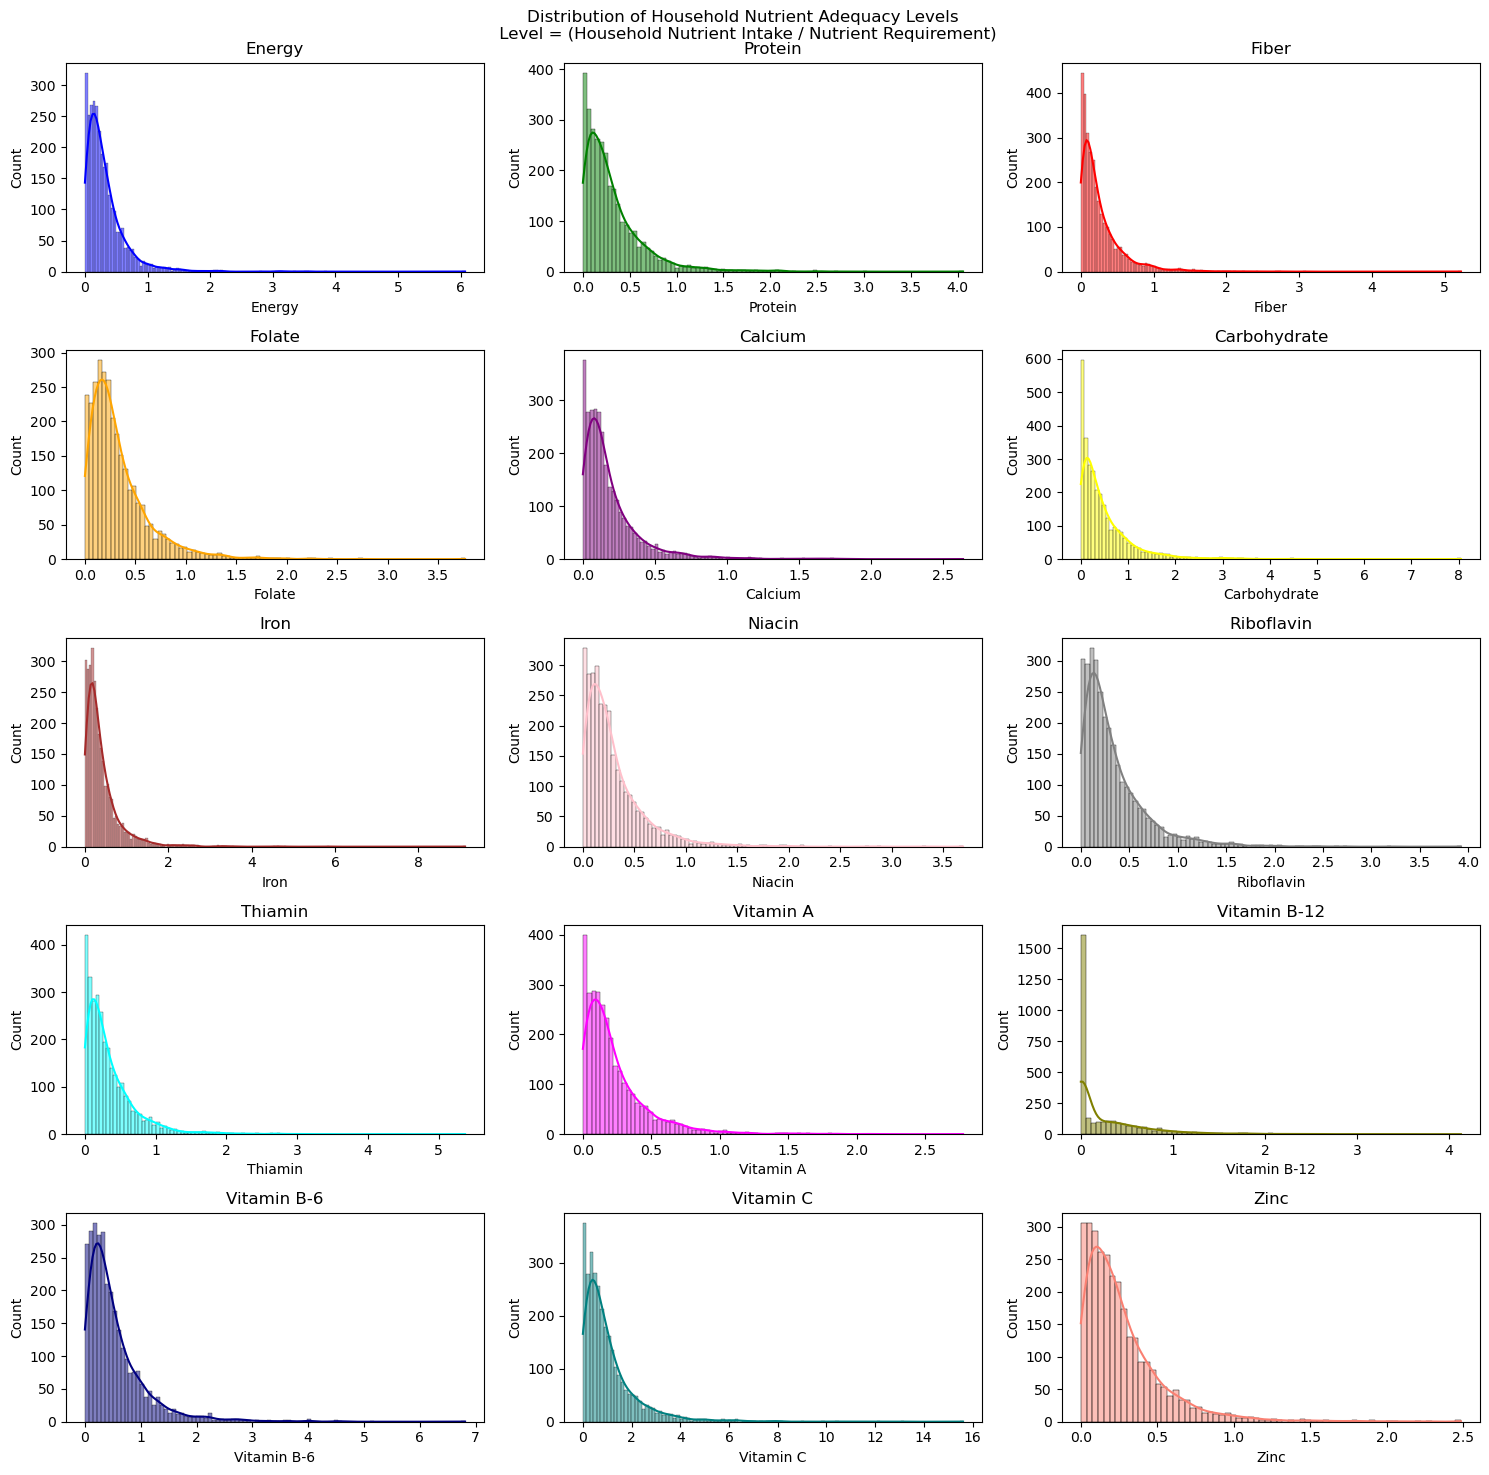

In [504]:
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

# Flatten the axs array for easy iteration
axs = axs.flatten()

colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive', 'navy', 'teal', 'salmon']

plt.suptitle('Distribution of Household Nutrient Adequacy Levels \n Level = (Household Nutrient Intake / Nutrient Requirement)')

# Loop through each column and plot its distribution
for i, col in enumerate(nutrient_cols):
    color = colors[i]
    sns.histplot(hh_diet_adequacy[col], ax=axs[i], kde=True, color=color)
    axs[i].set_title(col)

# Adjust layout to prevent overlapping
plt.tight_layout()

In [516]:
adequacy_shares = (hh_diet_adequacy > 1).mean()
adequacy_shares_75pct = (hh_diet_adequacy > 0.75).mean()
adequacy_shares_50pct = (hh_diet_adequacy > 0.5).mean()

# Calculate the average value of each column
avg_shares = hh_diet_adequacy.mean()

# Create a new DataFrame with the percentage over 1 and average values, indexed by column names
adequacy_shares_summary = pd.DataFrame({'Average Share': avg_shares, 
                                        'Adequacy Share (Full)': adequacy_shares,
                                       'Adequacy Share (75%)': adequacy_shares_75pct,
                                       'Adequacy Share (50%)': adequacy_shares_50pct})
adequacy_shares_summary = adequacy_shares_summary[adequacy_shares_summary.index.isin(nutrient_cols)]
adequacy_shares_summary

,Average Share,Adequacy Share (Full),Adequacy Share (75%),Adequacy Share (50%)
Energy,0.318788,0.037912,0.077153,0.179914
Protein,0.316648,0.042567,0.085800,0.193216
Fiber,0.262355,0.031593,0.064849,0.146325
Folate,0.332212,0.040572,0.089458,0.202527
Calcium,0.189404,0.012970,0.026272,0.073163
Carbohydrate,0.494387,0.129365,0.210841,0.330895
Iron,0.400802,0.078151,0.131693,0.253741
Niacin,0.293568,0.030928,0.071832,0.168274
Riboflavin,0.332754,0.048221,0.096442,0.210841
Thiamin,0.349545,0.056535,0.109744,0.228467


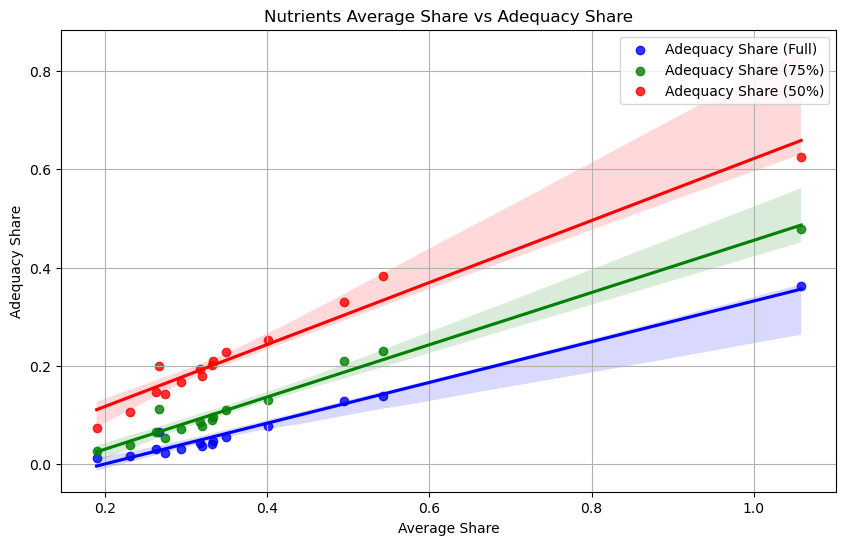

In [530]:
colors = ['blue', 'green', 'red', 'purple']

plt.figure(figsize=(10, 6))

for i, (col, color) in enumerate(zip(adequacy_shares_summary.columns[1:], colors)):
    sns.regplot(x='Average Share', y=col, data = adequacy_shares_summary,
                scatter= True, color = color, label = col)

plt.xlabel('Average Share')
plt.ylabel('Adequacy Share')
plt.title('Nutrients Average Share vs Adequacy Share')
plt.legend()
plt.grid(True)
plt.show()

In [534]:
adequacy_shares_summary.sort_values('Average Share', ascending = False).head()

,Average Share,Adequacy Share (Full),Adequacy Share (75%),Adequacy Share (50%)
Vitamin C,1.058585,0.363153,0.478217,0.625540
Vitamin B-6,0.543145,0.138344,0.229797,0.382774
Carbohydrate,0.494387,0.129365,0.210841,0.330895
Iron,0.400802,0.078151,0.131693,0.253741
Thiamin,0.349545,0.056535,0.109744,0.228467
